In [1]:
# make visible the only one GPU
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
print(tf.__version__)

2.0.0-alpha0


### Create a fashion-MNIST dataset

In [4]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [5]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

### Define the network as tf.keras.model object

In [6]:
class AE(tf.keras.Model):
    """a basic autoencoder class for tensorflow
    Extends:
        tf.keras.Model
    """
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        self.__dict__.update(kwargs)
        
        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    @tf.function
    def encode(self, x):
        return self.enc(x)

    @tf.function
    def decode(self, z):
        return self.dec(z)
    
    @tf.function
    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = tf.reduce_mean(tf.square(x - _x))
        return ae_loss
    
    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    def train(self, train_x):    
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) 

### Define the network architecture

In [7]:
N_Z = 64
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

### Create Model

In [8]:
# the optimizer for the model
optimizer = tf.keras.optimizers.Adam(1e-3)
# train the model
model = AE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

### Train the model

In [9]:
# exampled data for plotting results
example_data = next(iter(train_dataset))

def plot_reconstruction(model, example_data, nex=5, zm=3):

    example_data_reconstructed = model.decode(model.encode(example_data))
    fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(zm * nex, zm * 2))
    for exi in range(nex):
        axs[0, exi].matshow(
            example_data.numpy()[exi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
        )
        axs[1, exi].matshow(
            example_data_reconstructed.numpy()[exi].squeeze(),
            cmap=plt.cm.Greys,
            vmin=0,
            vmax=1,
        )
    for ax in axs.flatten():
        ax.axis("off")
    plt.show()

In [10]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['MSE'])

Epoch: 49 | MSE: 0.00520171457901597


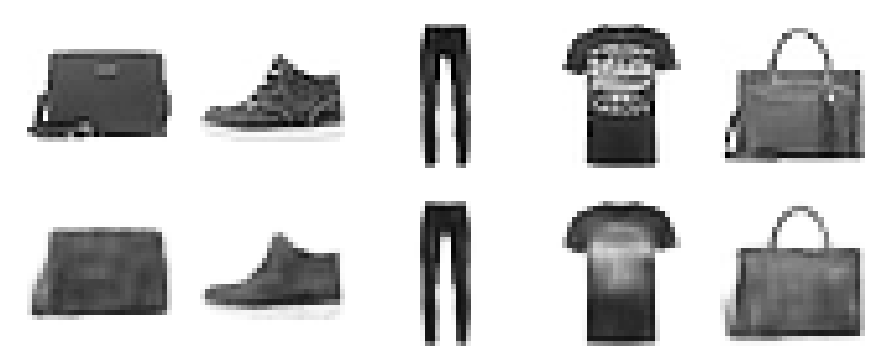

In [11]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print("Epoch: {} | MSE: {}".format(epoch, losses.MSE.values[-1]))
    plot_reconstruction(model, example_data)

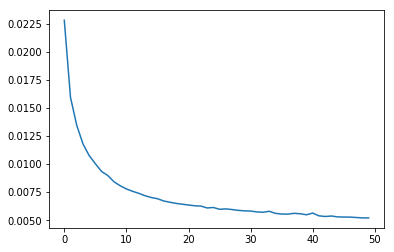

In [12]:
plt.plot(losses.MSE.values)